Let's begin to investigate how an imperfect drift-scan observation strategy will
affect the reconstruction of foreground alm.

In [1]:
from pygdsm import GlobalSkyModel2016
import healpy as hp
import numpy as np
from scipy.special import eval_legendre
import matplotlib.pyplot as plt
import seaborn as sns

import src.beam_functions as BF
import src.spherical_harmonics as SH
import src.forward_model as FM
import src.sky_models as SM
import src.map_making as MM

RS = SH.RealSphericalHarmonics()

3072 561


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


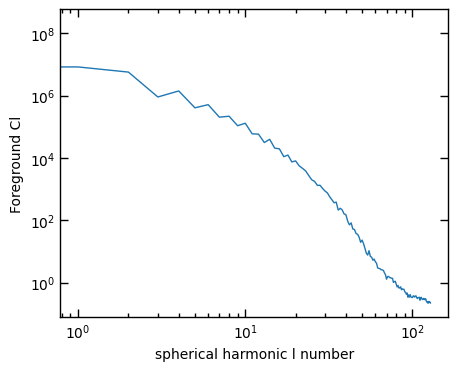

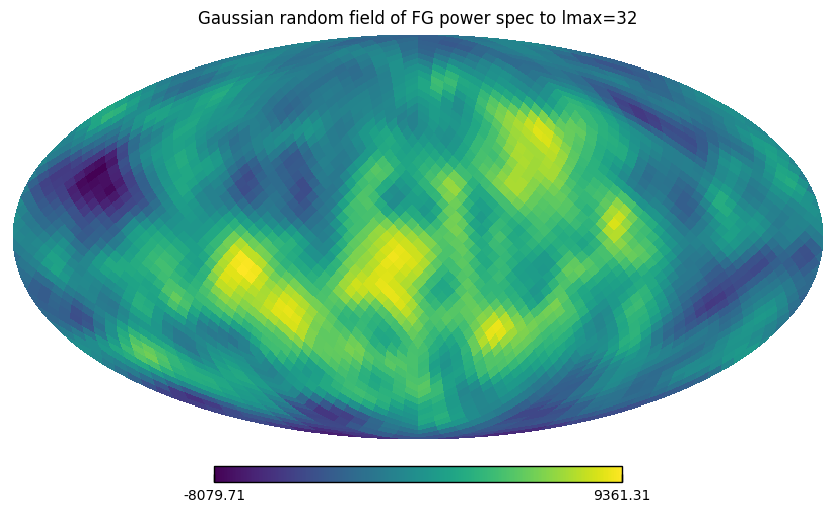

3072 561


In [2]:
lmax=32
nside=16
npix = hp.nside2npix(nside)
ylm_mat = SH.calc_spherical_harmonic_matrix(nside=nside, lmax=lmax)

# Generate foreground map.
fg_full_map = GlobalSkyModel2016(resolution='low').generate(60)
fg_cl = hp.sphtfunc.anafast(fg_full_map, lmax=64*2)
plt.loglog(fg_cl)
plt.xlabel("spherical harmonic l number")
plt.ylabel("Foreground Cl")
plt.show()

# Generate Gaussian field with the same Cl as the foreground map.
np.random.seed(124)
fg_gauss_map = hp.synfast(fg_cl, lmax=lmax, nside=nside)
hp.mollview(fg_gauss_map, title=f"Gaussian random field of FG power spec to lmax={lmax}")
plt.show()

# Convert Gaussian field to real alm.
fg_gauss_alm = hp.map2alm(fg_gauss_map, lmax=lmax)
fg_gauss_alm = RS.complex2RealALM(fg_gauss_alm)

# Observe the Gaussian random field.
narrow_cosbeam = lambda x : BF.beam_cos(x, theta0=0.8)
mat_A_fm = FM.calc_observation_matrix_all_pix(nside=nside, lmax=lmax, Ntau=npix, Nt=npix, beam_use=narrow_cosbeam)
d = mat_A_fm @ fg_gauss_alm

# Add noise.
d_noisy, noise_covar = SM.add_noise(d, 1, Ntau=npix, t_int=1e4, seed=124)